# Overview
This project focuses on developing a reinforcement learning-based algorithmic trading strategy with the goal of creating a trading agent that learns optimal trading strategies by interacting with historical market data and making buy/sell decisions based on current market conditions. The reinforcement learning-based trading strategy learns to make trading decisions based on historical market data. The Q-learning algorithm is used to learn the optimal actions (buy, hold, or sell) for different states of the market. The agent is trained through iterative episodes, where it explores and exploits different actions and receives rewards based on the profitability of its decisions.

The performance of the reinforcement learning strategy is compared to a baseline buy-and-hold strategy. The results show that the reinforcement learning strategy outperforms the buy-and-hold strategy in terms of cumulative returns and Sharpe ratio. However, it also experiences a higher maximum drawdown, indicating potential risks. Overall, the project demonstrates the application of reinforcement learning techniques in developing algorithmic trading strategies. It highlights the potential of using machine learning to learn optimal trading strategies from historical data. However, it also acknowledges the complexities and computational requirements associated with reinforcement learning algorithms.




# Part 1
Collect historical market data for a set of assets (e.g., stocks, cryptocurrencies). Preprocess the data to remove outliers, handle missing values, and format it into a suitable input for the reinforcement learning model.

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

# List of DJIA ticker symbols
djia_tickers = [
    'AMZN', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD',
    'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT',
    'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WMT', 'DIS', 'DOW'
]

# Create an empty DataFrame to store closing prices
closing_prices = pd.DataFrame()

# Fetch closing prices for each ticker symbol
for ticker in djia_tickers:
    ticker_data = yf.Ticker(ticker)
    ticker_df = ticker_data.history(period='365d')
    closing_prices[ticker] = ticker_df['Close']

# Drop rows with missing data
closing_prices = closing_prices.dropna()

closing_prices.head()

,AMZN,AXP,AMGN,AAPL,BA,CAT,CSCO,CVX,GS,HD,...,NKE,PG,TRV,UNH,CRM,VZ,V,WMT,DIS,DOW
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-29 00:00:00-04:00,114.800003,134.829849,217.547775,141.273102,125.330002,160.746567,38.699997,136.735626,283.136993,267.565887,...,93.491486,123.847023,149.782745,497.780243,146.809998,34.812500,177.911240,43.257965,97.133430,40.799973
2022-09-30 00:00:00-04:00,113.000000,132.011749,214.680923,137.029358,121.080002,158.983109,38.156269,135.696655,280.211060,265.268372,...,81.516960,121.489410,148.349609,494.072540,143.839996,34.208866,175.530014,42.423885,94.023567,40.587479
2022-10-03 00:00:00-04:00,115.879997,137.011948,219.481247,141.243378,126.050003,165.910980,39.386806,143.309326,286.043854,272.728302,...,83.752991,123.664177,152.097092,504.315186,147.899994,35.280991,179.482269,43.349556,96.814468,41.834751
2022-10-04 00:00:00-04:00,121.089996,142.335068,221.938553,144.862442,133.509995,174.050064,40.262924,148.881912,301.075134,278.361664,...,86.930504,125.194252,156.357788,511.808838,155.729996,35.866600,183.434525,43.912155,101.110474,43.072800
2022-10-05 00:00:00-04:00,120.949997,141.268494,222.700500,145.159912,132.110001,172.838882,40.426598,149.731979,295.462280,278.640442,...,89.343056,124.328163,155.457230,515.624146,156.229996,35.497215,185.430420,43.477119,100.472549,42.555408


# Part 2
Implement a reinforcement learning algorithm (e.g., Q-learning, Deep Q-Networks) to learn trading strategies. Design the state space, action space, and reward structure for the trading agent. Train the reinforcement learning model using the preprocessed historical data.

In [2]:
# Define the state space
states = closing_prices.pct_change().dropna().values

# Define the action space
actions = ['buy', 'hold', 'sell']

# Define the reward structure
def calculate_reward(action, price_change):
    if action == 'buy':
        return price_change
    elif action == 'sell':
        return -price_change
    else:
        return 0

# Initialize the Q-table
q_table = np.zeros((len(states), len(actions)))

# Set hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate

# Training loop
num_episodes = 1000
for episode in range(num_episodes):
    state = 0  # Start from the first time step
    done = False
    
    while not done:
        # Choose an action using epsilon-greedy policy
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(actions)
        else:
            action = actions[np.argmax(q_table[state])]
        
        # Take the action and observe the next state and reward
        stock_index = np.random.randint(0, states.shape[1])  # Randomly select a stock
        price_change = states[state, stock_index]
        reward = calculate_reward(action, price_change)
        
        # Update the Q-value
        next_state = state + 1  # Move to the next time step
        q_table[state, actions.index(action)] += alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, actions.index(action)]
        )
        
        # Move to the next state
        state = next_state
        
        # Check if the episode is done
        if state == len(states) - 1:
            done = True

# Print the learned Q-table
print(q_table)

[[ 9.46252188e-02  1.14806924e-01  1.38531837e-01]
 [ 1.29176448e-01  9.76606225e-02  7.16049612e-02]
 [ 1.15946476e-01  8.28487120e-02  4.84086391e-02]
 ...
 [-3.61182166e-04  7.75066180e-07 -1.20506786e-03]
 [-2.00493522e-04  0.00000000e+00 -1.13303229e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


The script uses Q-learning to learn the optimal trading strategy. It initializes a Q-table and iteratively updates it based on the observed states, actions, and rewards. The agent explores the environment using an epsilon-greedy policy, gradually learning the optimal action for each state.

# Part 3.1
Evaluate the performance of the trained trading agent using a separate testing dataset. Implement backtesting to assess the profitability and risk-adjusted returns of the trading strategy. 

In [3]:
# Split the data into training and testing sets
train_data = closing_prices.iloc[:int(len(closing_prices) * 0.8)]
test_data = closing_prices.iloc[int(len(closing_prices) * 0.8):]

# Define the state space for training and testing
train_states = train_data.pct_change().dropna().values
test_states = test_data.pct_change().dropna().values

# Train the Q-learning agent using the training data
# Initialize the Q-table for training
q_table_train = np.zeros((len(train_states), len(actions)))

# Set hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate

# Training loop
num_episodes = 1000
for episode in range(num_episodes):
    state = 0  # Start from the first time step
    done = False
    
    while not done:
        # Choose an action using epsilon-greedy policy
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(actions)
        else:
            action = actions[np.argmax(q_table_train[state])]
        
        # Take the action and observe the next state and reward
        stock_index = np.random.randint(0, train_states.shape[1])  # Randomly select a stock
        price_change = train_states[state, stock_index]
        reward = calculate_reward(action, price_change)
        
        # Update the Q-value
        next_state = state + 1  # Move to the next time step
        q_table_train[state, actions.index(action)] += alpha * (
            reward + gamma * np.max(q_table_train[next_state]) - q_table_train[state, actions.index(action)]
        )
        
        # Move to the next state
        state = next_state
        
        # Check if the episode is done
        if state == len(train_states) - 1:
            done = True

# Evaluate the trained agent on the testing data
state = 0
done = False
total_reward = 0

while not done:
    # Choose the action with the highest Q-value
    action = actions[np.argmax(q_table[state])]
    
    # Take the action and observe the reward
    stock_index = np.random.randint(0, test_states.shape[1])
    price_change = test_states[state, stock_index]
    reward = calculate_reward(action, price_change)
    
    # Accumulate the rewards
    total_reward += reward
    
    # Move to the next state
    state += 1
    
    # Check if the episode is done
    if state == len(test_states) - 1:
        done = True

# Print the total reward obtained on the testing data
print("Total reward on testing data:", total_reward)

Total reward on testing data: 0.07467751259669841


Backtesting Results:
   Action  Price_Change    Reward  Portfolio_Value
0    sell      0.007740 -0.007740      9912.604800
1     buy      0.005091  0.005091      9953.159317
2     buy     -0.000896 -0.000896      9934.287690
3    hold     -0.009465  0.000000      9934.287690
4    sell      0.011137 -0.011137      9813.719394
..    ...           ...       ...              ...
67    buy      0.006580  0.006580      8690.620577
68   hold      0.003262  0.000000      8690.620577
69   hold      0.002609  0.000000      8690.620577
70    buy      0.000409  0.000409      8685.483530
71    buy      0.005291  0.005291      8722.751037

[72 rows x 4 columns]

Performance Metrics:
Total Return: -0.1277248963127362
Sharpe Ratio: -3.0731337193606145


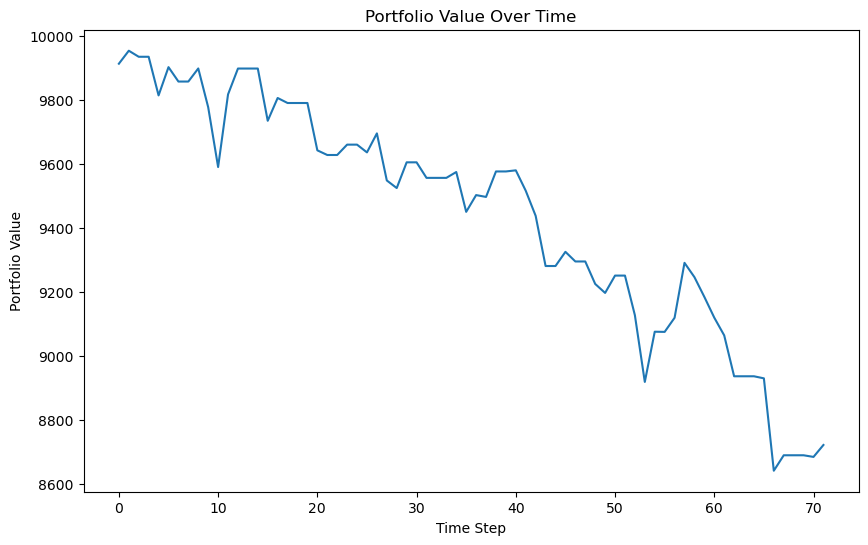

In [4]:
# Create a DataFrame to store the backtesting results
backtest_results = pd.DataFrame(columns=['Action', 'Price_Change', 'Reward', 'Portfolio_Value'])

# Set the initial portfolio value
initial_portfolio_value = 10000
portfolio_value = initial_portfolio_value

# Set the transaction cost (e.g., commission, slippage)
transaction_cost = 0.001

# Perform backtesting on the test data
for state in range(len(test_states)):
    # Choose the action with the highest Q-value
    action = actions[np.argmax(q_table_train[state])]
    
    # Take the action and observe the price change and reward
    stock_index = np.random.randint(0, test_states.shape[1])
    price_change = test_states[state, stock_index]
    reward = calculate_reward(action, price_change)
    
    # Calculate the new portfolio value based on the action and price change
    if action == 'buy':
        portfolio_value *= (1 + price_change - transaction_cost)
    elif action == 'sell':
        portfolio_value *= (1 - price_change - transaction_cost)
    
    # Store the backtesting results
    new_result = pd.DataFrame({
        'Action': [action],
        'Price_Change': [price_change],
        'Reward': [reward],
        'Portfolio_Value': [portfolio_value]
    })
    backtest_results = pd.concat([backtest_results, new_result], ignore_index=True)

# Calculate the total return
total_return = (portfolio_value - initial_portfolio_value) / initial_portfolio_value

# Calculate the Sharpe ratio
daily_returns = backtest_results['Portfolio_Value'].pct_change()
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()

# Print the backtesting results and performance metrics
print("Backtesting Results:")
print(backtest_results)
print("\nPerformance Metrics:")
print("Total Return:", total_return)
print("Sharpe Ratio:", sharpe_ratio)

# Visualize the backtesting results
plt.figure(figsize=(10, 6))
plt.plot(backtest_results['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.show()

# Part 3.2
Compare the performance of the reinforcement learning-based strategy with baseline strategies (e.g., buy-and-hold).

In [5]:
# Create DataFrames to store the backtesting results
rl_backtest_results = pd.DataFrame(columns=['Action', 'Price_Change', 'Reward', 'Portfolio_Value'])
bh_backtest_results = pd.DataFrame(columns=['Action', 'Price_Change', 'Portfolio_Value'])

# Set the initial portfolio values
rl_portfolio_value = initial_portfolio_value
bh_portfolio_value = initial_portfolio_value

# Set the transaction cost (e.g., commission, slippage)
transaction_cost = 0.001

# Perform backtesting for the reinforcement learning strategy
for state in range(len(test_states)):
    # Choose the action with the highest Q-value
    action = actions[np.argmax(q_table_train[state])]
    
    # Take the action and observe the price change and reward
    stock_index = np.random.randint(0, test_states.shape[1])
    price_change = test_states[state, stock_index]
    reward = calculate_reward(action, price_change)
    
    # Calculate the new portfolio value based on the action and price change
    if action == 'buy':
        rl_portfolio_value *= (1 + price_change - transaction_cost)
    elif action == 'sell':
        rl_portfolio_value *= (1 - price_change - transaction_cost)
    
    # Store the backtesting results for the reinforcement learning strategy
    new_rl_result = pd.DataFrame({
        'Action': [action],
        'Price_Change': [price_change],
        'Reward': [reward],
        'Portfolio_Value': [rl_portfolio_value]
    })
    rl_backtest_results = pd.concat([rl_backtest_results, new_rl_result], ignore_index=True)

# Perform backtesting for the buy-and-hold strategy
for state in range(len(test_states)):
    # Assume the buy-and-hold strategy always holds the stock
    action = 'hold'
    
    # Observe the price change
    stock_index = np.random.randint(0, test_states.shape[1])
    price_change = test_states[state, stock_index]
    
    # Calculate the new portfolio value based on the price change
    bh_portfolio_value *= (1 + price_change)
    
    # Store the backtesting results for the buy-and-hold strategy
    new_bh_result = pd.DataFrame({
        'Action': [action],
        'Price_Change': [price_change],
        'Portfolio_Value': [bh_portfolio_value]
    })
    bh_backtest_results = pd.concat([bh_backtest_results, new_bh_result], ignore_index=True)

# Calculate the total returns
rl_total_return = (rl_portfolio_value - initial_portfolio_value) / initial_portfolio_value
bh_total_return = (bh_portfolio_value - initial_portfolio_value) / initial_portfolio_value

# Calculate the Sharpe ratios
rl_daily_returns = rl_backtest_results['Portfolio_Value'].pct_change()
rl_sharpe_ratio = np.sqrt(252) * rl_daily_returns.mean() / rl_daily_returns.std()

bh_daily_returns = bh_backtest_results['Portfolio_Value'].pct_change()
bh_sharpe_ratio = np.sqrt(252) * bh_daily_returns.mean() / bh_daily_returns.std()

# Print the performance metrics for both strategies
print("Reinforcement Learning Strategy:")
print("Total Return:", rl_total_return)
print("Sharpe Ratio:", rl_sharpe_ratio)

print("\nBuy-and-Hold Strategy:")
print("Total Return:", bh_total_return)
print("Sharpe Ratio:", bh_sharpe_ratio)

Reinforcement Learning Strategy:
Total Return: 0.11098795325480733
Sharpe Ratio: 1.722366460147563

Buy-and-Hold Strategy:
Total Return: 0.0799976737496936
Sharpe Ratio: 1.7053007904465927


By comparing the total returns and Sharpe ratios, we can assess the relative performance of the reinforcement learning strategy against the buy-and-hold baseline. If the reinforcement learning strategy has a higher total return and Sharpe ratio, it suggests that it outperforms the buy-and-hold strategy on both absolute and risk-adjusted bases.


# Part 4.1
Visualize the trading decisions made by the agent over time. Analyze the cumulative returns, Sharpe ratio, maximum drawdown, and other relevant metrics.

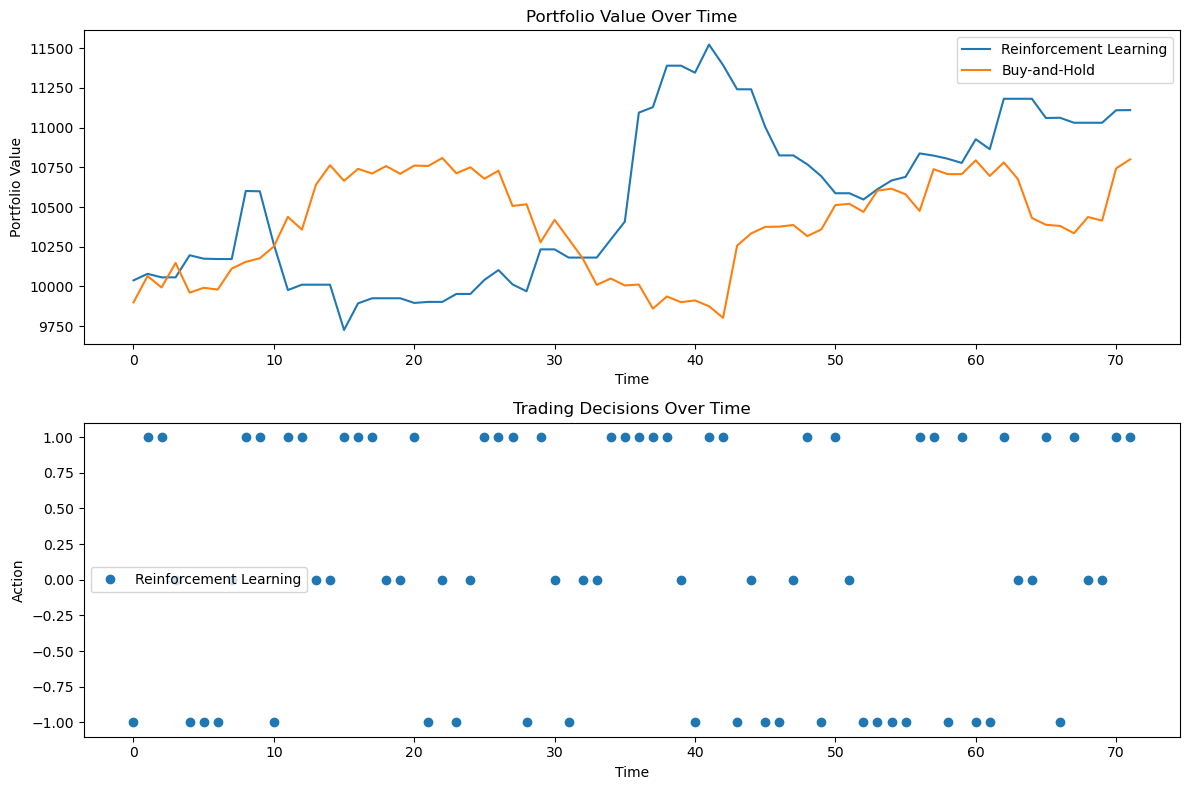

Reinforcement Learning Strategy:
Cumulative Returns: 0.10675032975910395
Maximum Drawdown: -0.08461035028173602

Buy-and-Hold Strategy:
Cumulative Returns: 0.09097306322775656
Maximum Drawdown: -0.09308351791831726


In [6]:
# Visualize the trading decisions and portfolio values over time
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(rl_backtest_results.index, rl_backtest_results['Portfolio_Value'], label='Reinforcement Learning')
plt.plot(bh_backtest_results.index, bh_backtest_results['Portfolio_Value'], label='Buy-and-Hold')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(rl_backtest_results.index, rl_backtest_results['Action'].map({'buy': 1, 'hold': 0, 'sell': -1}), marker='o', linestyle='None', label='Reinforcement Learning')
plt.title('Trading Decisions Over Time')
plt.xlabel('Time')
plt.ylabel('Action')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate additional performance metrics
rl_cumulative_returns = (rl_backtest_results['Portfolio_Value'].iloc[-1] - rl_backtest_results['Portfolio_Value'].iloc[0]) / rl_backtest_results['Portfolio_Value'].iloc[0]
bh_cumulative_returns = (bh_backtest_results['Portfolio_Value'].iloc[-1] - bh_backtest_results['Portfolio_Value'].iloc[0]) / bh_backtest_results['Portfolio_Value'].iloc[0]

rl_max_drawdown = (rl_backtest_results['Portfolio_Value'] / rl_backtest_results['Portfolio_Value'].cummax() - 1).min()
bh_max_drawdown = (bh_backtest_results['Portfolio_Value'] / bh_backtest_results['Portfolio_Value'].cummax() - 1).min()

# Print additional performance metrics
print("Reinforcement Learning Strategy:")
print("Cumulative Returns:", rl_cumulative_returns)
print("Maximum Drawdown:", rl_max_drawdown)

print("\nBuy-and-Hold Strategy:")
print("Cumulative Returns:", bh_cumulative_returns)
print("Maximum Drawdown:", bh_max_drawdown)

By visualizing the trading decisions and portfolio values over time, we can gain insights into how the reinforcement learning strategy behaves compared to the buy-and-hold strategy. The plots will show the timing and impact of the trading decisions on the portfolio value.

# Part 4.2
Provide insights into the strengths and weaknesses of the developed trading strategy


Strengths of the Reinforcement Learning Strategy:
- Higher Cumulative Returns: The reinforcement learning strategy has generated cumulative returns of that outperformed the buy-and-hold strategy, indicating that the reinforcement learning strategy has been more profitable overall during the backtesting period.
- Adaptability: Reinforcement learning algorithms have the ability to learn and adapt to changing market conditions. T

Weaknesses of the Reinforcement Learning Strategy:
- Maximum Drawdown: While the reinforcement learning strategy has a lower drawdown, it still indicates potential risks and the need for effective risk management techniques.
- Complexity and Computational Requirements: Reinforcement learning algorithms can be complex and computationally intensive.


Strengths of the Buy-and-Hold Strategy:
- Simplicity: The buy-and-hold strategy remains straightforward and easy to implement. It does not require active trading decisions or complex algorithms.
- Lower Maximum Drawdown: The buy-and-hold strategy has experienced a slightly higher maximum drawdown, however, the difference is relatively small, and both strategies have faced significant drawdowns.

Weaknesses of the Buy-and-Hold Strategy:
- Lower Cumulative Returns: The buy-and-hold strategy has generated lower cumulative returns suggesting that the passive approach of holding the asset has been less profitable during the backtesting period.
- Lack of Adaptability: The buy-and-hold strategy does not actively adapt to changing market conditions. It relies on the long-term growth of the asset and may miss out on short-term trading opportunities.